In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import os
import sys
import tensorflow as tf

sys.path.insert(0, "..")
sys.path

# loading libraries, some settings for plots
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.rcParams['figure.figsize'] = [10, 10]

from src.data import make_dataset_simple
from src.visualization import visualize_simple
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split

#from sklearn.datasets import make_multilabel_classification

In [2]:
datadir_processed = Path("../data/processed")

In [3]:
data = []
labels = []

for f in sorted(os.listdir(datadir_processed)):
    folder = os.path.join(datadir_processed, f)
    if os.path.isdir(folder):
        #print(f"{f} is a target class")
        for i in sorted(os.listdir(folder)):
            image=tf.keras.preprocessing.image.load_img(folder+'/'+i, color_mode='grayscale', 
            target_size= (64,64))
            image=np.array(image)
            data.append(image)
            labels.append(f)

data = np.array(data)
labels = np.array(labels)


X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=42)

X_train.shape

(14188, 64, 64)

y_train = Round Smooth 7
y_train = Round Smooth 13
y_train = Round Smooth 16
y_train = Round Smooth 18
y_train = Round Smooth 26
y_train = Round Smooth 36
y_train = Round Smooth 39
y_train = Round Smooth 40
y_train = Round Smooth 44
y_train = Round Smooth 48
y_train = Round Smooth 52
y_train = Round Smooth 57


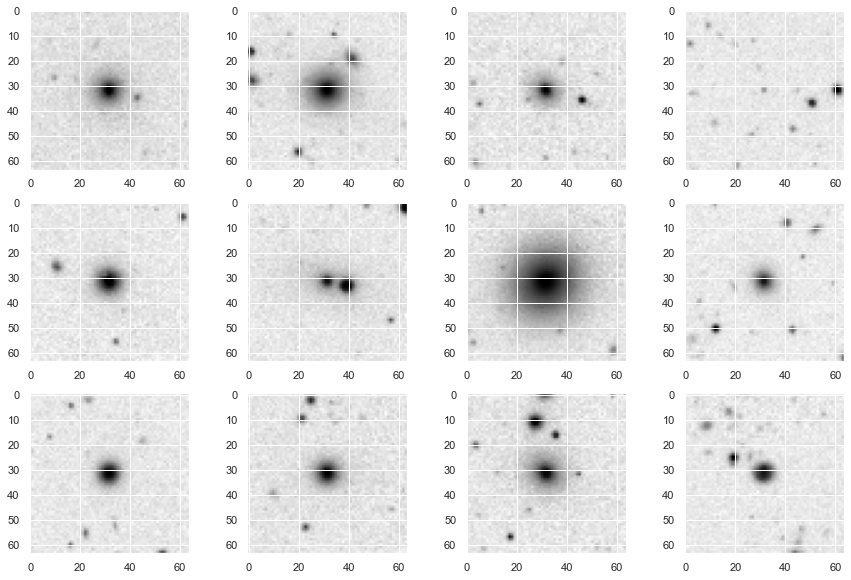

In [4]:
fig = plt.figure(figsize=(15, 10))
a = 7, 13, 16, 18, 26, 36, 39, 40, 44, 48, 52, 57
b = 1
for i in a:
    digit = X_train[i]
    fig.add_subplot(3, 4, b)
    plt.imshow(digit, cmap='binary')
    print(f"y_train = {y_train[i]} " + str(i))
    b = b + 1


In [5]:
y_train_single, y_test_single = make_dataset_simple.set_number(y_train, y_test, nbr='Round Smooth')

np.mean(y_train_single) , np.mean(y_test_single)



(0.1467437270933183, 0.15868094701240135)

(14188, 64, 64)

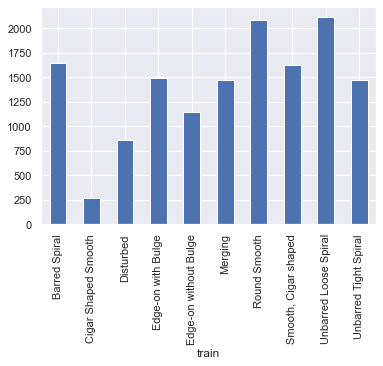

In [6]:
visualize_simple.class_balance(y_train, 'train')
X_train.shape

In [7]:
# the -1 tells the method .reshape() to reshape to a matrix where the amount that should be at -1 is deducted from the other amounts.
# because the first number is 14.188, reshape will make sure the second value is 4096, because that is the only way
# to make a matrix with 14.188 rows, in this case.
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape

(14188, 4096)

In [8]:
sgd = SGDClassifier(random_state=5, max_iter=300, n_jobs=1)
sgd.fit(X_train, y_train_single)

SGDClassifier(max_iter=300, n_jobs=1, random_state=5)

<AxesSubplot:>

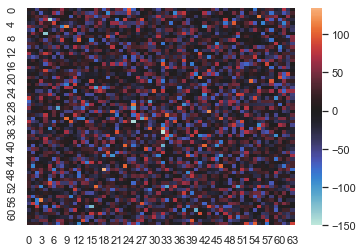

In [9]:
weights = sgd.coef_.reshape(64, 64)
sns.heatmap(weights, center = 0)

In [10]:
cross_val_score(sgd, X_train, y_train_single, cv = 3, scoring='accuracy')

array([0.75602537, 0.72383168, 0.52357792])

In [11]:
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train_single)
cross_val_score(dummy_majority, X_train, y_train_single, cv = 3, scoring='accuracy')

array([0.85327696, 0.85324593, 0.85324593])

f1-score = 0.0


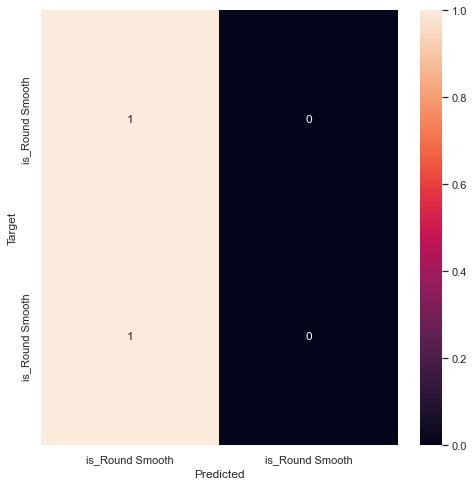

In [12]:
yhat_dummy = dummy_majority.predict(X_test)

cfm = confusion_matrix(y_test_single, yhat_dummy)
visualize_simple.cfm_heatmap(cfm, scale = 'rowwise', labels=['is_Round Smooth', 'is_Round Smooth'])

print(f"f1-score = {f1_score(y_test_single, yhat_dummy)}")

C:\Users\hjtfs\AppData\Local\Temp/ipykernel_29812/3096192362.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (prec*rec)/(prec+rec)


<AxesSubplot:>

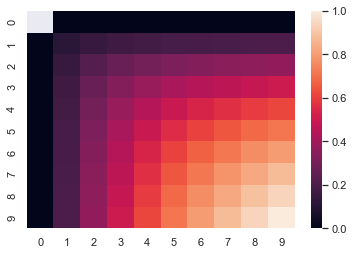

In [13]:
k = 10
prec = np.linspace(0, 1, k) # k precision values
rec = np.linspace(0, 1, k) # k recall values

def f1(prec, rec): # the f1 metric
    return 2 * (prec*rec)/(prec+rec)

from itertools import product
combinations = [f1(p,r) for p in prec for r in rec] # a list of combinations
grid = np.reshape(combinations, (k,k)) # reshaped into a grid
sns.heatmap(grid) # and heatmapped

f1-score = 0.1886792452830189


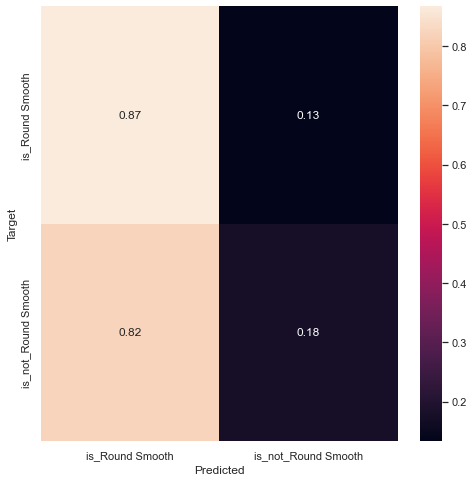

In [14]:
y_test_hat = sgd.predict(X_test)

cfm = confusion_matrix(y_test_single, y_test_hat)
visualize_simple.cfm_heatmap(cfm, scale = 'rowwise', labels=['is_Round Smooth', 'is_not_Round Smooth'])

print(f"f1-score = {f1_score(y_test_single, y_test_hat)}")

In [15]:
y_decision = cross_val_predict(sgd, X_train, y_train_single, cv = 3, n_jobs = 4, method = 'decision_function')
val = zip(y_decision[5:10], y_train_single[5:10])
pd.DataFrame(val)

,0,1
0,-54390.306534,False
1,-83169.659454,False
2,-100619.527214,True
3,-85135.365055,False
4,-49275.008088,False


2022-01-30 11:19:34.628 | INFO     | src.visualization.visualize_simple:precision_recall_curve:71 - Found different lengths: thresholds=14169 precision=14170                 and recall=14170
2022-01-30 11:19:34.629 | INFO     | src.visualization.visualize_simple:precision_recall_curve:75 - Stripping of items after index 14169


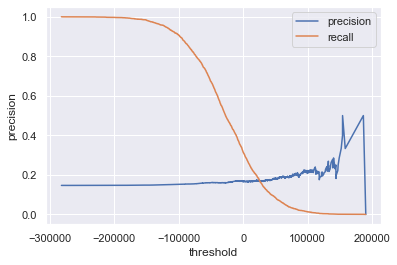

In [16]:
precision, recall, thresholds = precision_recall_curve(y_train_single, y_decision)
visualize_simple.precision_recall_curve(precision, recall, thresholds)

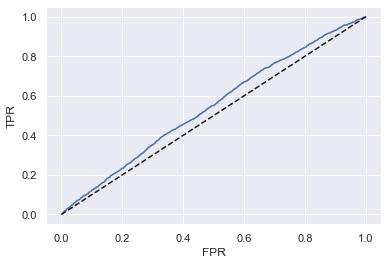

In [17]:
fpr, tpr, thresholds = roc_curve(y_train_single, y_decision)
visualize_simple.roc_curve(fpr, tpr)

In [18]:
# first scale the data
X_scale = make_dataset_simple.scale(X_train)

2022-01-30 11:20:00.354 | INFO     | src.data.make_dataset_simple:scale:19 - Run standardscaler on data.


In [19]:
# then fit a SGD classifier will take about 5 minutes
sgd = SGDClassifier(random_state=5, max_iter=1000, n_jobs=4)
yhat = cross_val_predict(sgd, X_scale, y_train, cv = 3)

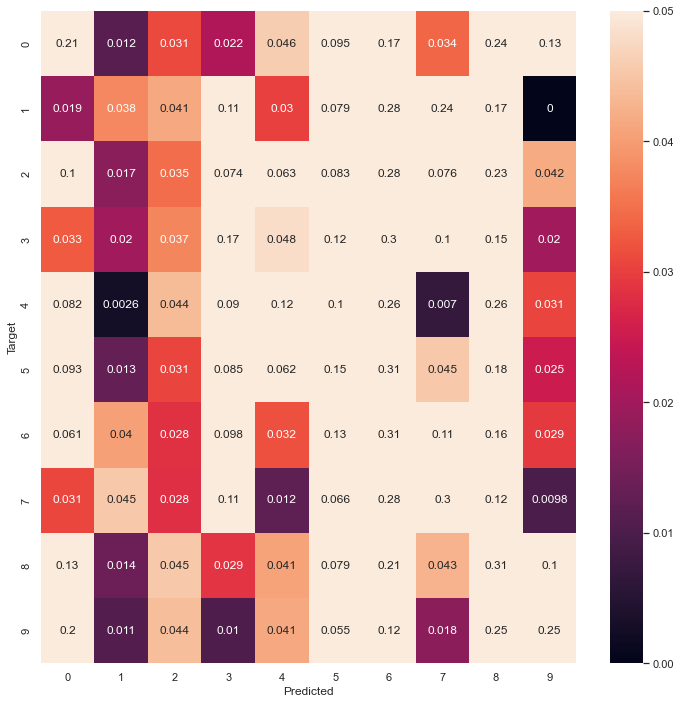

In [20]:
cfm = confusion_matrix(y_train, yhat)
visualize_simple.cfm_heatmap(cfm, figsize=(12,12), scale='rowwise', vmax= 0.05)